In [1]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def read_df(input_file):
    return pd.read_csv(input_file, index_col='test_number')

filepath = r"Y:\allen\scratch\aindtemp\cameron.arshadi\compression-metrics_02-10_exm-hemi-brain.zarr.csv"
df = read_df(filepath)

In [3]:
def barplot(df, ax, x_key, y_key, secondary_y_key=None, bar_width=0.2, title=None, **kwargs):
    if secondary_y_key is not None:
        ax2 = ax.twinx()
    for i, compressor in enumerate(df['compressor_name'].unique().tolist()):
        filtered_df = df[df['compressor_name'] == compressor]
        default_title = []
        for key, val in kwargs.items():
            filtered_df = filtered_df[filtered_df[key] == val]
            default_title.append(f"{key}={val}")
        default_title = ", ".join(default_title)
        mean_df = filtered_df.groupby([x_key]).mean().sort_index()
        x = mean_df.index.to_numpy()
        y = mean_df[y_key].to_numpy()
        a = np.arange(len(x))
        yerr = filtered_df.groupby([x_key]).std().sort_index()[y_key].to_numpy()
        ax.bar(a + (i * bar_width), y, bar_width, yerr=yerr, label=compressor)
        ax.set_xticks(a)
        ax.set_xticklabels(x)
        if secondary_y_key is not None:
            t = mean_df[secondary_y_key].to_numpy()
            ax2.plot(a, t)
            ax2.set_xticks(a)
            ax2.set_ylabel(secondary_y_key)
    ax.set_ylabel(y_key)
    ax.grid(axis='y')
    ax.set_xlabel(x_key)
    if title is None:
        ax.set_title(default_title)
    else:
        ax.set_title(title)


def bargrid(df, x_keys, y_keys, secondary_y_key, defaults, rows, cols, figsize, bar_width=0.2):
    """grid of barplots. rows * cols should equal |x_keys| * |y_keys|"""
    keys = list(itertools.product(x_keys, y_keys))
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, xy_keys in enumerate(keys):
        defaults_no_x = defaults.copy()
        if xy_keys[0] in defaults_no_x:
            defaults_no_x.pop(xy_keys[0])  # remove varying parameter from defaults
        barplot(
            df=df,
            ax=axes.ravel()[i],
            x_key=xy_keys[0],
            y_key=xy_keys[1],
            secondary_y_key=secondary_y_key,
            bar_width=bar_width,
            **defaults_no_x
        )
    handles, labels = axes.ravel()[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

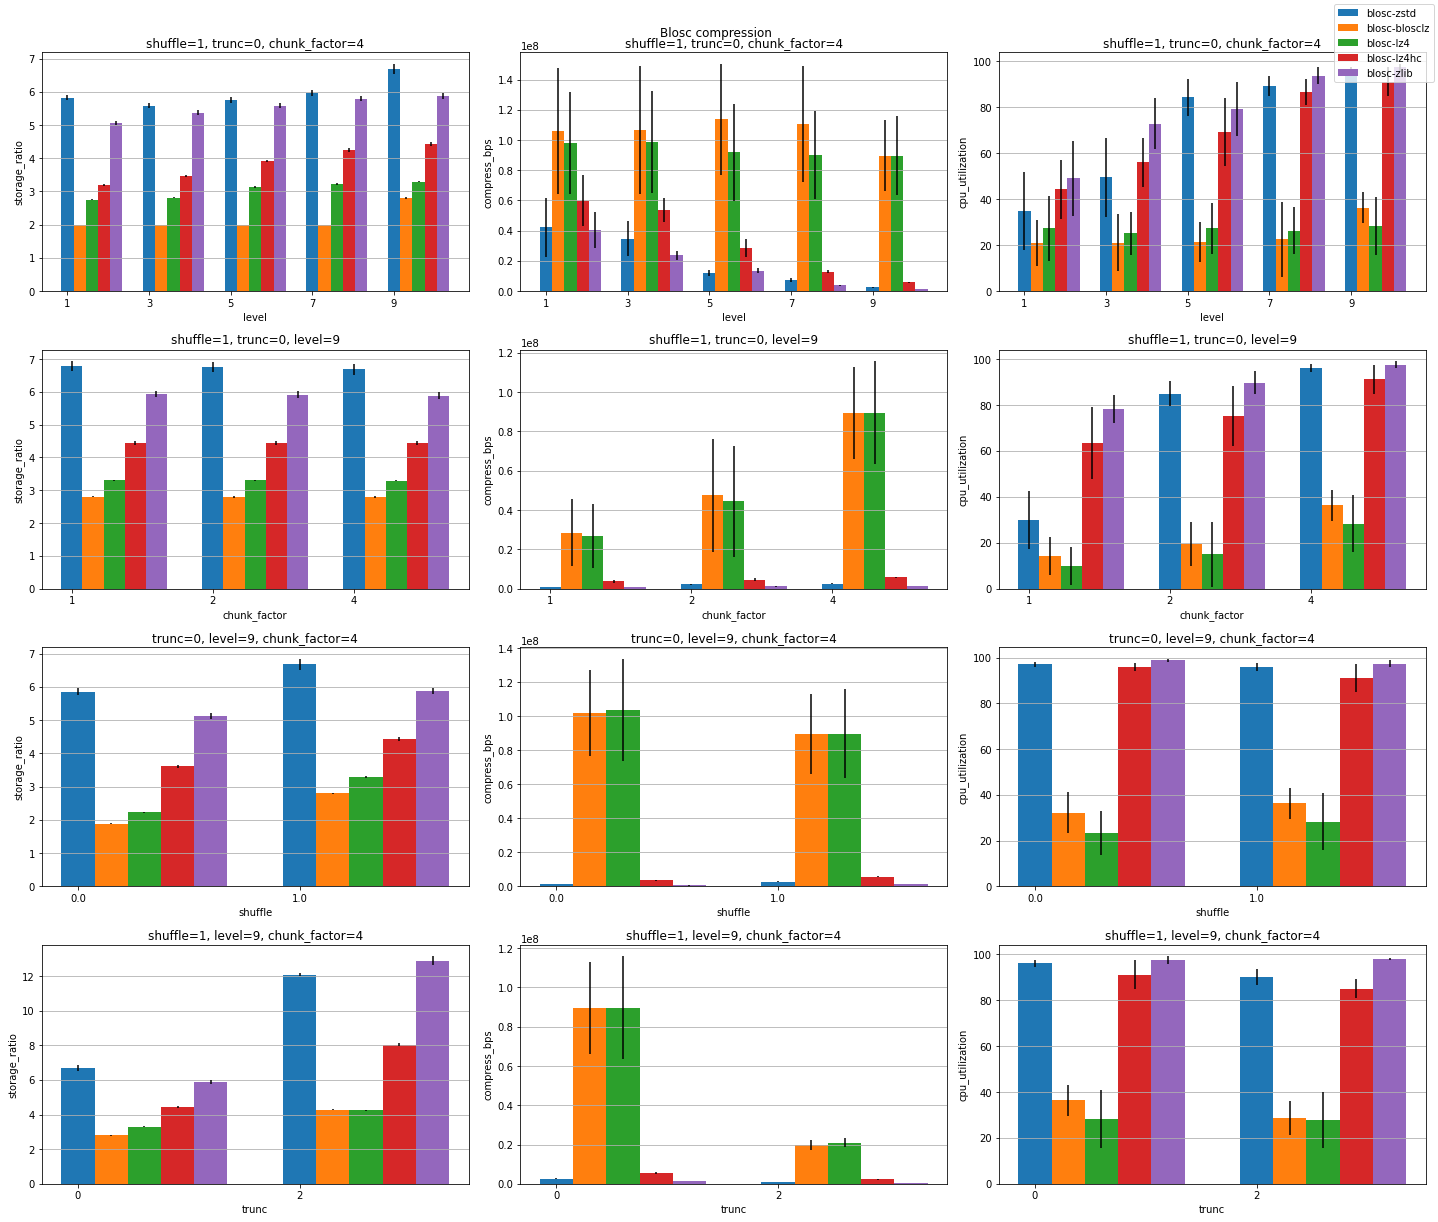

In [4]:
blosc_df = df[df['compressor_name'].str.contains('blosc')]

x_keys = ['level',  'chunk_factor', 'shuffle', 'trunc']
y_keys = ['storage_ratio', 'compress_bps', 'cpu_utilization']
defaults = {
    'shuffle': 1,
    'trunc': 0,
    'level': 9,
    'chunk_factor': 4
}

# number of plots == product of x and y keys
rows = 4
cols = 3
bargrid(blosc_df, x_keys, y_keys, None, defaults, rows, cols, figsize=(20,17), bar_width=0.15)
plt.suptitle(f"Blosc compression")
plt.tight_layout()

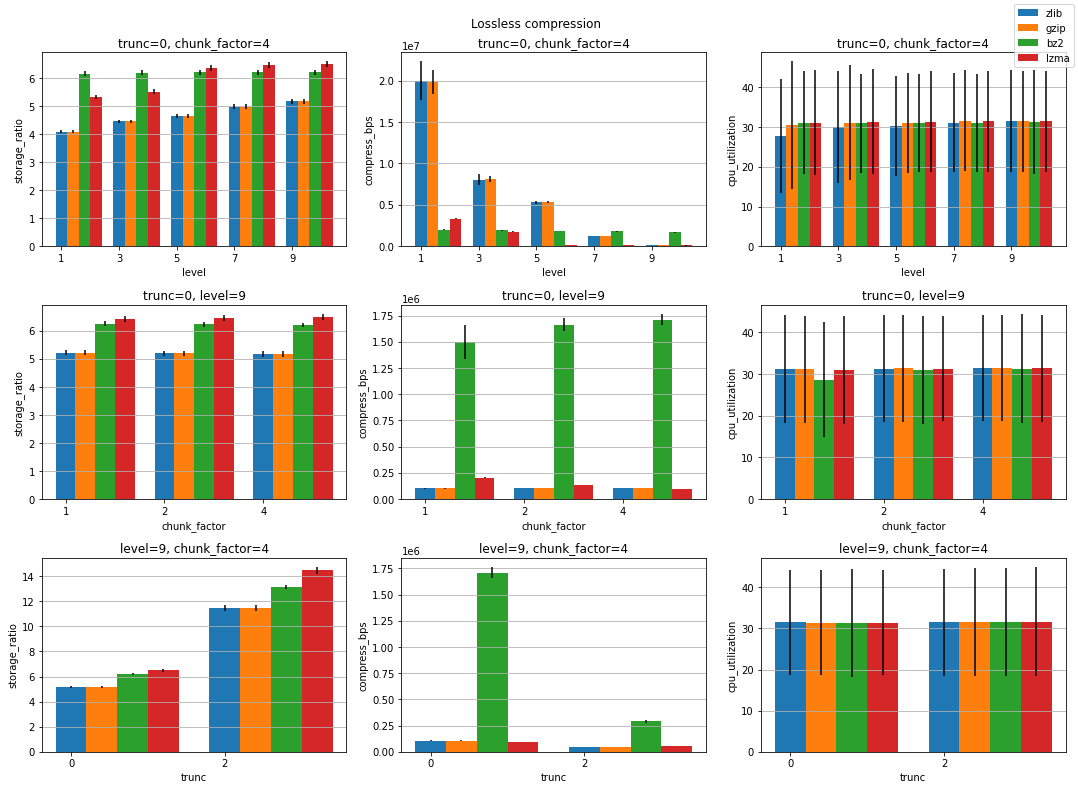

In [5]:
lossless_df = df[~df['compressor_name'].str.contains('blosc')]

x_keys = ['level', 'chunk_factor', 'trunc']
y_keys = ['storage_ratio', 'compress_bps', 'cpu_utilization']
defaults = {
    'trunc': 0,
    'level': 9,
    'chunk_factor': 4
}

rows = 3
cols = 3
bargrid(lossless_df, x_keys, y_keys, None, defaults, rows, cols, figsize=(15,11))
plt.suptitle("Lossless compression")
plt.tight_layout()

In [6]:
def plot_ratios(df, y_labels, title):
    """adapted from http://alimanfoo.github.io/2016/09/21/genotype-compression-benchmark.html"""
    fig, ax = plt.subplots(figsize=(7, df.shape[0] * .25))
    ax.barh(y=np.arange(df.shape[0]), width=df['storage_ratio'].tolist(), height=.8)
    ax.set_yticks(np.arange(df.shape[0]) + .4)
    data = []
    for l in y_labels:
        data.append(df[l])
    ax.set_yticklabels(df[y_labels].apply(tuple, axis=1))
    ax.set_ylabel(", ".join(y_labels))
    ax.grid(axis='x')
    ax.set_xlabel('Storage ratio')
    ax.autoscale(axis='y')
    ax.set_title(title, va='bottom')
    
def plot_speed(df, y_labels, title):
    """adapted from http://alimanfoo.github.io/2016/09/21/genotype-compression-benchmark.html"""
    fig, ax = plt.subplots(figsize=(7, df.shape[0] * .25))
    x = df['compress_bps'] / (2**20)  # MiB/s
    ax.barh(y=np.arange(df.shape[0]), width=x, height=.8)
    # plot data points
    y = np.arange(df.shape[0]) + .4
    ax.plot(x, y, marker='o', linestyle=' ', color='k', markersize=2)
    ax.set_yticks(np.arange(df.shape[0]) + .4)
    ax.set_yticklabels(df[y_labels].apply(tuple, axis=1))
    ax.set_ylabel(", ".join(y_labels))
    ax.grid(axis='x')
    ax.set_xlabel('Speed (MiB/s)')
    ax.autoscale(axis='y', tight=True)
    ax.set_title(title, va='bottom')
    for i, (xi, ri) in enumerate(zip(x, df['storage_ratio'])):
        ax.annotate('%.1fX' % ri, xy=(xi, i + .4), xytext=(5, 0),
                    textcoords='offset points', ha='left', va='center',
                    fontsize=8)

In [7]:
trunc = 0
y_labels = ['compressor_name', 'shuffle', 'level', 'chunk_factor']
blosc_df_trunc = blosc_df[blosc_df['trunc'] == trunc]
blosc_df_trunc = blosc_df_trunc.groupby(y_labels).mean().reset_index()

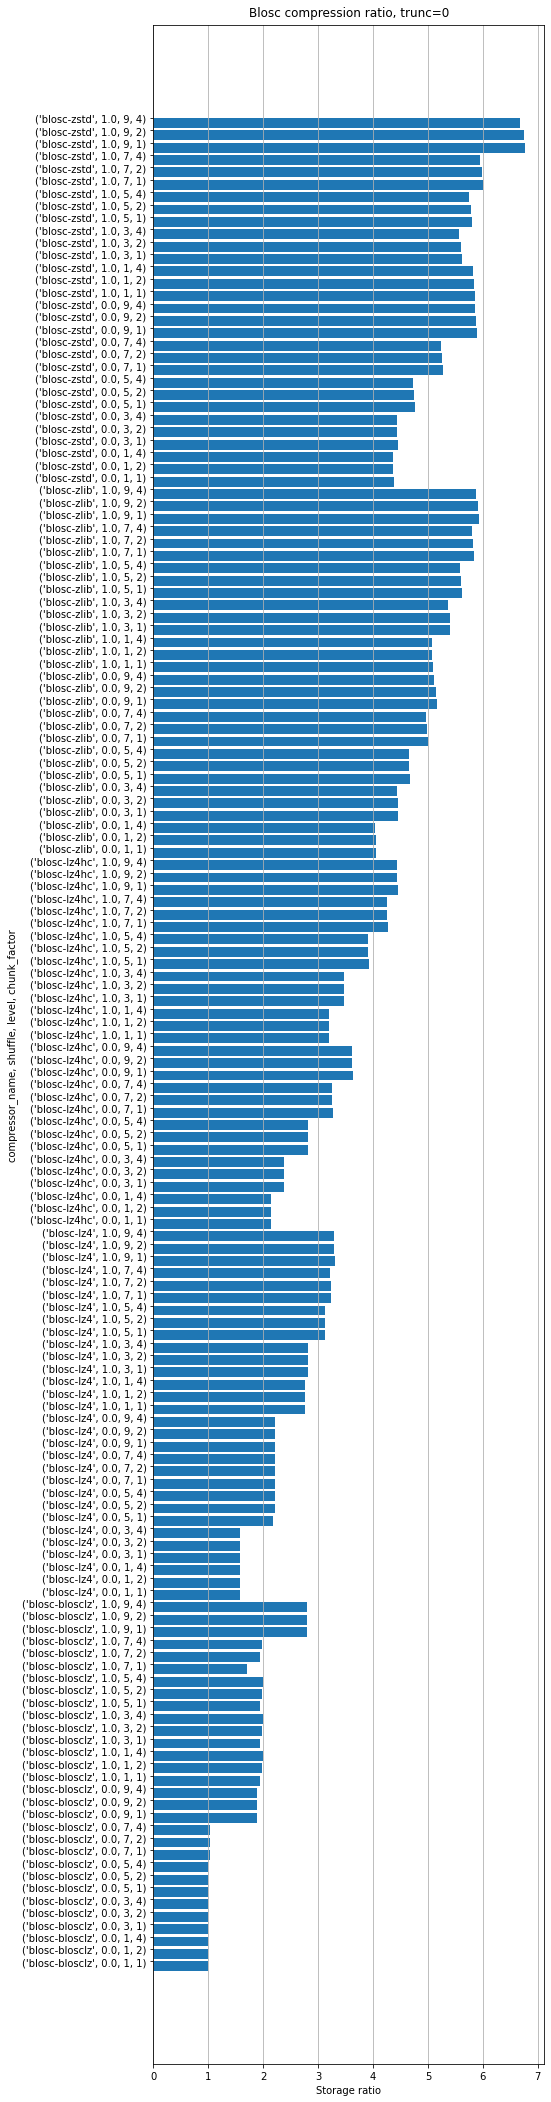

In [8]:
plot_ratios(blosc_df_trunc, y_labels, f"Blosc compression ratio, trunc={trunc}")

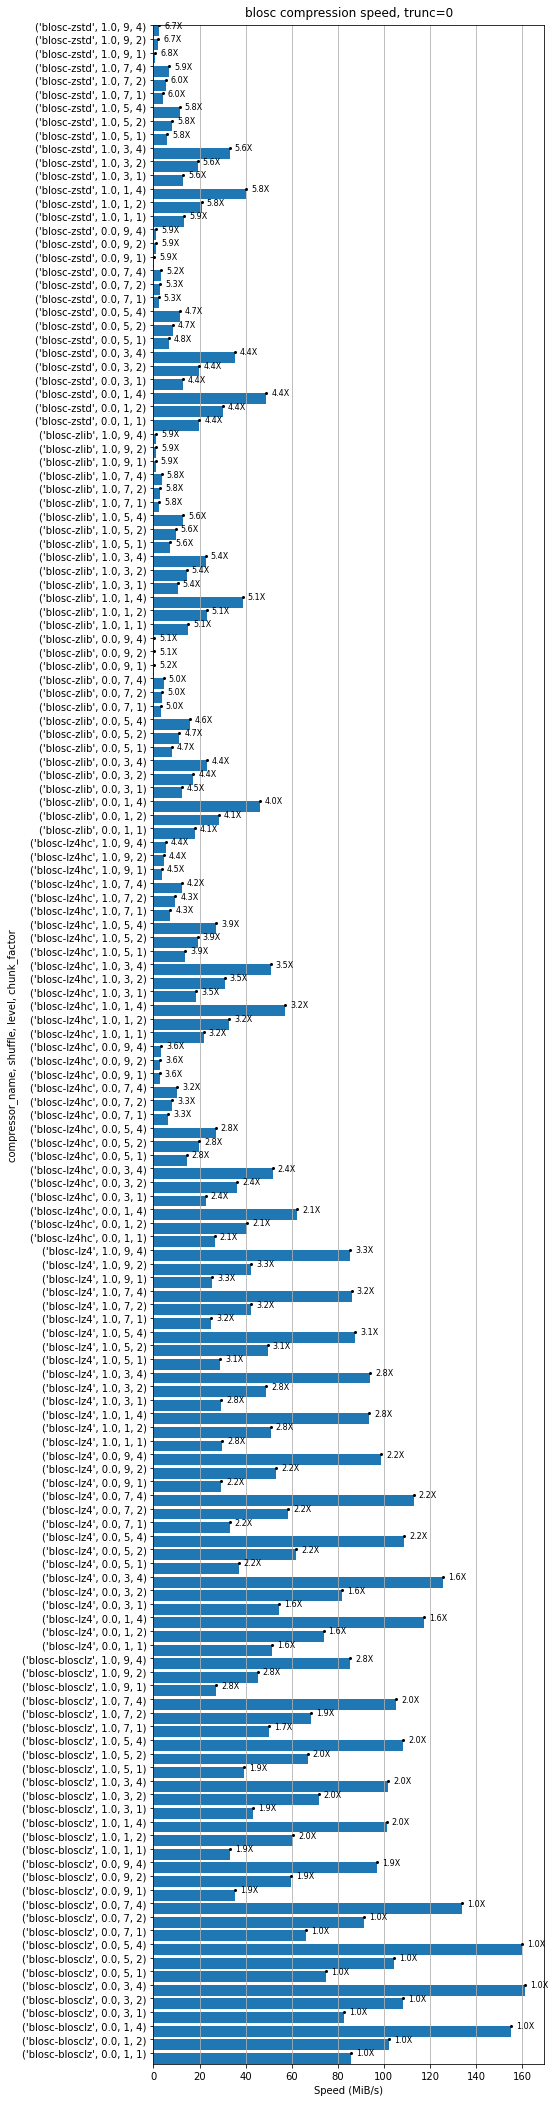

In [9]:
plot_speed(blosc_df_trunc, y_labels, f"blosc compression speed, trunc={trunc}")

In [10]:
trunc = 0

lossless_df_trunc = lossless_df[lossless_df['trunc'] == trunc]
# shuffle is not a key for the lossless compressor library
y_labels = ['compressor_name', 'level', 'chunk_factor']
lossless_df_trunc = lossless_df_trunc.groupby(y_labels).mean().reset_index()

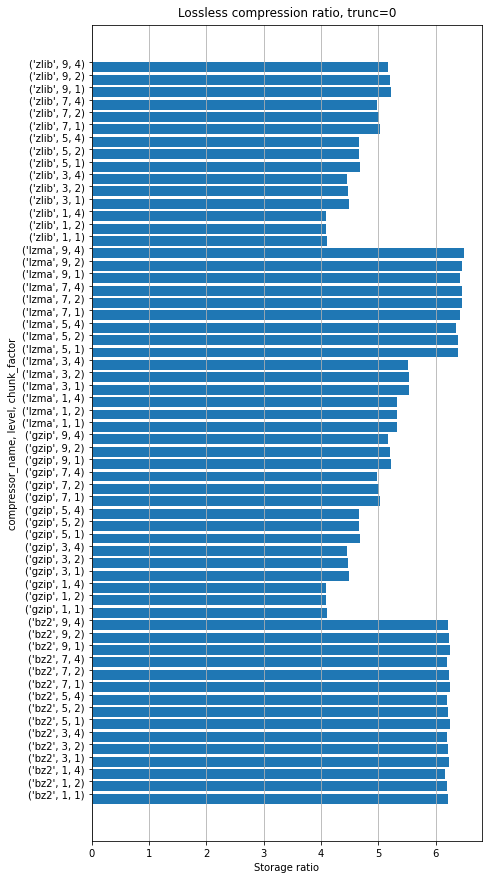

In [11]:
plot_ratios(lossless_df_trunc, y_labels, f"Lossless compression ratio, trunc={trunc}")

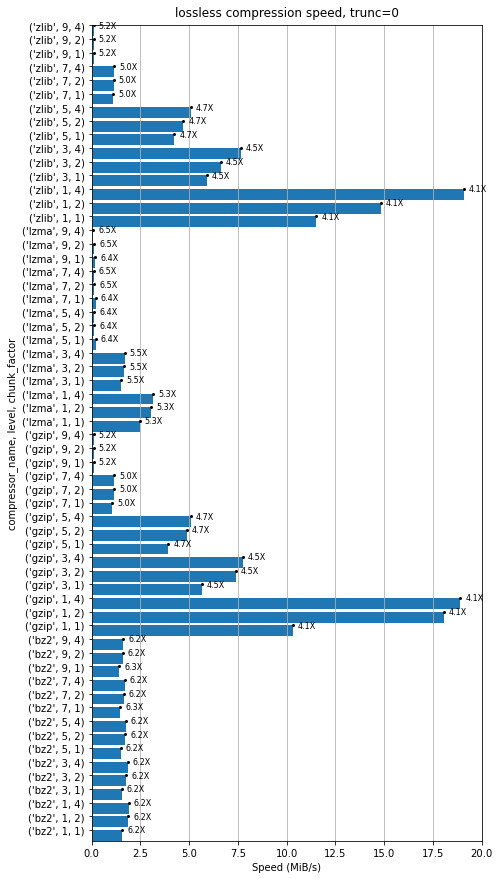

In [12]:
plot_speed(lossless_df_trunc, y_labels, f"lossless compression speed, trunc={trunc}")

C:\Users\cameron.arshadi\Miniconda3\envs\lightsheet-compression-pyimagej\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\cameron.arshadi\Miniconda3\envs\lightsheet-compression-pyimagej\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
C:\Users\cameron.arshadi\Miniconda3\envs\lightsheet-compression-pyimagej\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\cameron.arshadi\Miniconda3\envs\lightsheet-compression-pyimagej\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
C:\Users\cameron.arshadi\Miniconda3\envs\lightsheet-

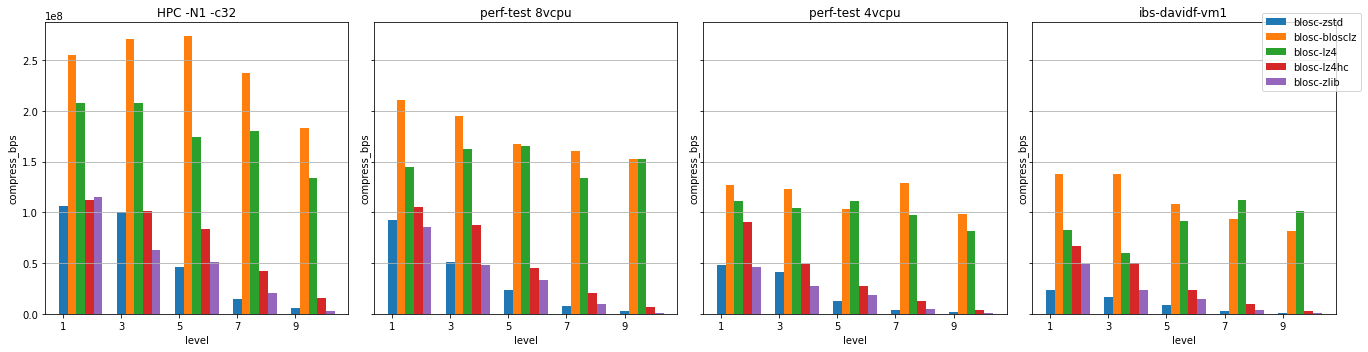

In [13]:
fig, ax = plt.subplots(1,4, sharey=True, figsize=(19,5))

x_key = 'level'
y_key = 'compress_bps'
defaults = {
    'trunc': 0,
    'shuffle': 0,
    'chunk_factor': 4,
    'tile': "s48"
}

barplot(
    read_df(r"Y:\allen\scratch\aindtemp\cameron.arshadi\compression-metrics_02-16_HPC_32c_16gb_res1_write_b4_exm-hemi-brain.zarr.csv"),
    ax[0],
    x_key,
    y_key,
    title="HPC -N1 -c32",
    bar_width=0.15,
    **defaults
)

barplot(
    read_df(r"Y:\allen\scratch\aindtemp\cameron.arshadi\compression-metrics_02-14_perf-test_exm-hemi-brain.zarr.csv"),
    ax[1],
    x_key,
    y_key,
    title="perf-test 8vcpu",
    bar_width=0.15,
    **defaults 
)

barplot(
    read_df(r"Y:\allen\scratch\aindtemp\cameron.arshadi\compression-metrics_02-14_perf-test_4vcpu_8gbram_exm-hemi-brain.zarr.csv"),
    ax[2],
    x_key,
    y_key,
    title="perf-test 4vcpu",
    bar_width=0.15,
    **defaults
)

barplot(
    blosc_df,
    ax[3],
    x_key,
    y_key,
    title="ibs-davidf-vm1",
    bar_width=0.15,
    **defaults
)

ax[3].legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()

C:\Users\cameron.arshadi\Miniconda3\envs\lightsheet-compression-pyimagej\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\cameron.arshadi\Miniconda3\envs\lightsheet-compression-pyimagej\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
C:\Users\cameron.arshadi\Miniconda3\envs\lightsheet-compression-pyimagej\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\cameron.arshadi\Miniconda3\envs\lightsheet-compression-pyimagej\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
C:\Users\cameron.arshadi\Miniconda3\envs\lightsheet-

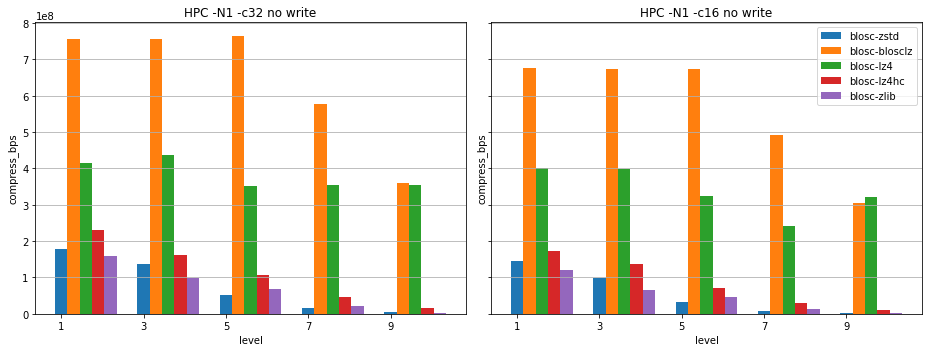

In [18]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(13,5))

x_key = 'level'
y_key = 'compress_bps'
defaults = {
    'trunc': 0,
    'shuffle': 0,
    'tile': "s48"
}

barplot(
    read_df(r"Y:\allen\scratch\aindtemp\cameron.arshadi\compression-metrics_02-16_HPC_32c_16gb_res1_nowrite_b4_exm-hemi-brain.zarr.csv"),
    ax[0], 
    x_key, 
    y_key,
    title="HPC -N1 -c32 no write",
    bar_width=0.15,
    **defaults
)


barplot(
    read_df(r"Y:\allen\scratch\aindtemp\cameron.arshadi\compression-metrics_02-16_HPC_16c_16gb_res1_nowrite_b4_exm-hemi-brain.zarr.csv"),
    ax[1], 
    x_key, 
    y_key,
    title="HPC -N1 -c16 no write",
    bar_width=0.15,
    **defaults
)

ax[1].legend()
plt.tight_layout()

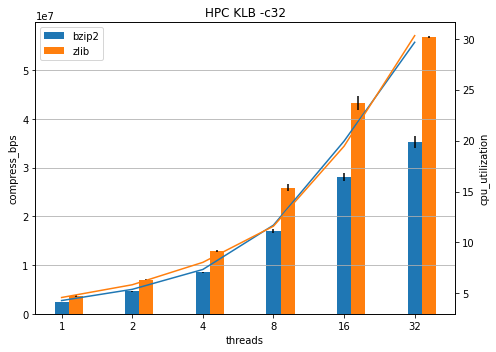

In [19]:
klb_df = read_df(r"Y:\allen\scratch\aindtemp\cameron.arshadi\klb-compression-metrics-HPC-32c_BrainSlice1_MMStack_Pos33_15_shift.tif.csv")

x_key = 'threads'
y_key = 'compress_bps'

fig, ax = plt.subplots(figsize=(7,5))
barplot(klb_df, ax, x_key, y_key, secondary_y_key='cpu_utilization', title='HPC KLB -c32', bar_width=0.2)
ax.legend()
plt.tight_layout()